## Dependencies

In [1]:
import pandas as pd
import numpy as np
import math as mt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

%matplotlib inline

---

## Circle

$$area = \pi r^2$$
$$perimeter = 2 \pi r$$
$$area = (\frac{perimeter}{2})^2 \div \pi$$

In [2]:
# Set seed
rng = np.random.default_rng(seed=0)

radius_train = rng.integers(low=1, high=100, size=8000)
radius_test = rng.integers(low=1, high=100, size=2000)

In [3]:
# Define ciricle to store radius, perimeter, and area
circle_train = pd.DataFrame({'r': radius_train})
# perimeter of circle = 2 * pi * r
circle_train['perimeter'] = 2 * radius_train * mt.pi
# area of circle = pi * r^2
circle_train['area'] = radius_train**2 * mt.pi
# add irrelevant column
circle_train['irr_col'] = rng.integers(low=0, high=100, size=8000)
# add pi
circle_train['pi'] = [mt.pi] * 8000

# Define ciricle to store radius, perimeter, and area
circle_test = pd.DataFrame({'r': radius_test})
# perimeter of circle = 2 * pi * r
circle_test['perimeter'] = 2 * radius_test * mt.pi
# area of circle = pi * r^2
circle_test['area'] = radius_test**2 * mt.pi
# add irrelevant column
circle_test['irr_col'] = rng.integers(low=0, high=100, size=2000)
# add pi
circle_test['pi'] = [mt.pi] * 2000

circle_train.head()

,r,perimeter,area,irr_col,pi
0,85,534.070751,22698.006922,68,3.141593
1,64,402.123860,12867.963509,88,3.141593
2,51,320.442451,8171.282492,49,3.141593
3,27,169.646003,2290.221044,69,3.141593
4,31,194.778745,3019.070540,74,3.141593


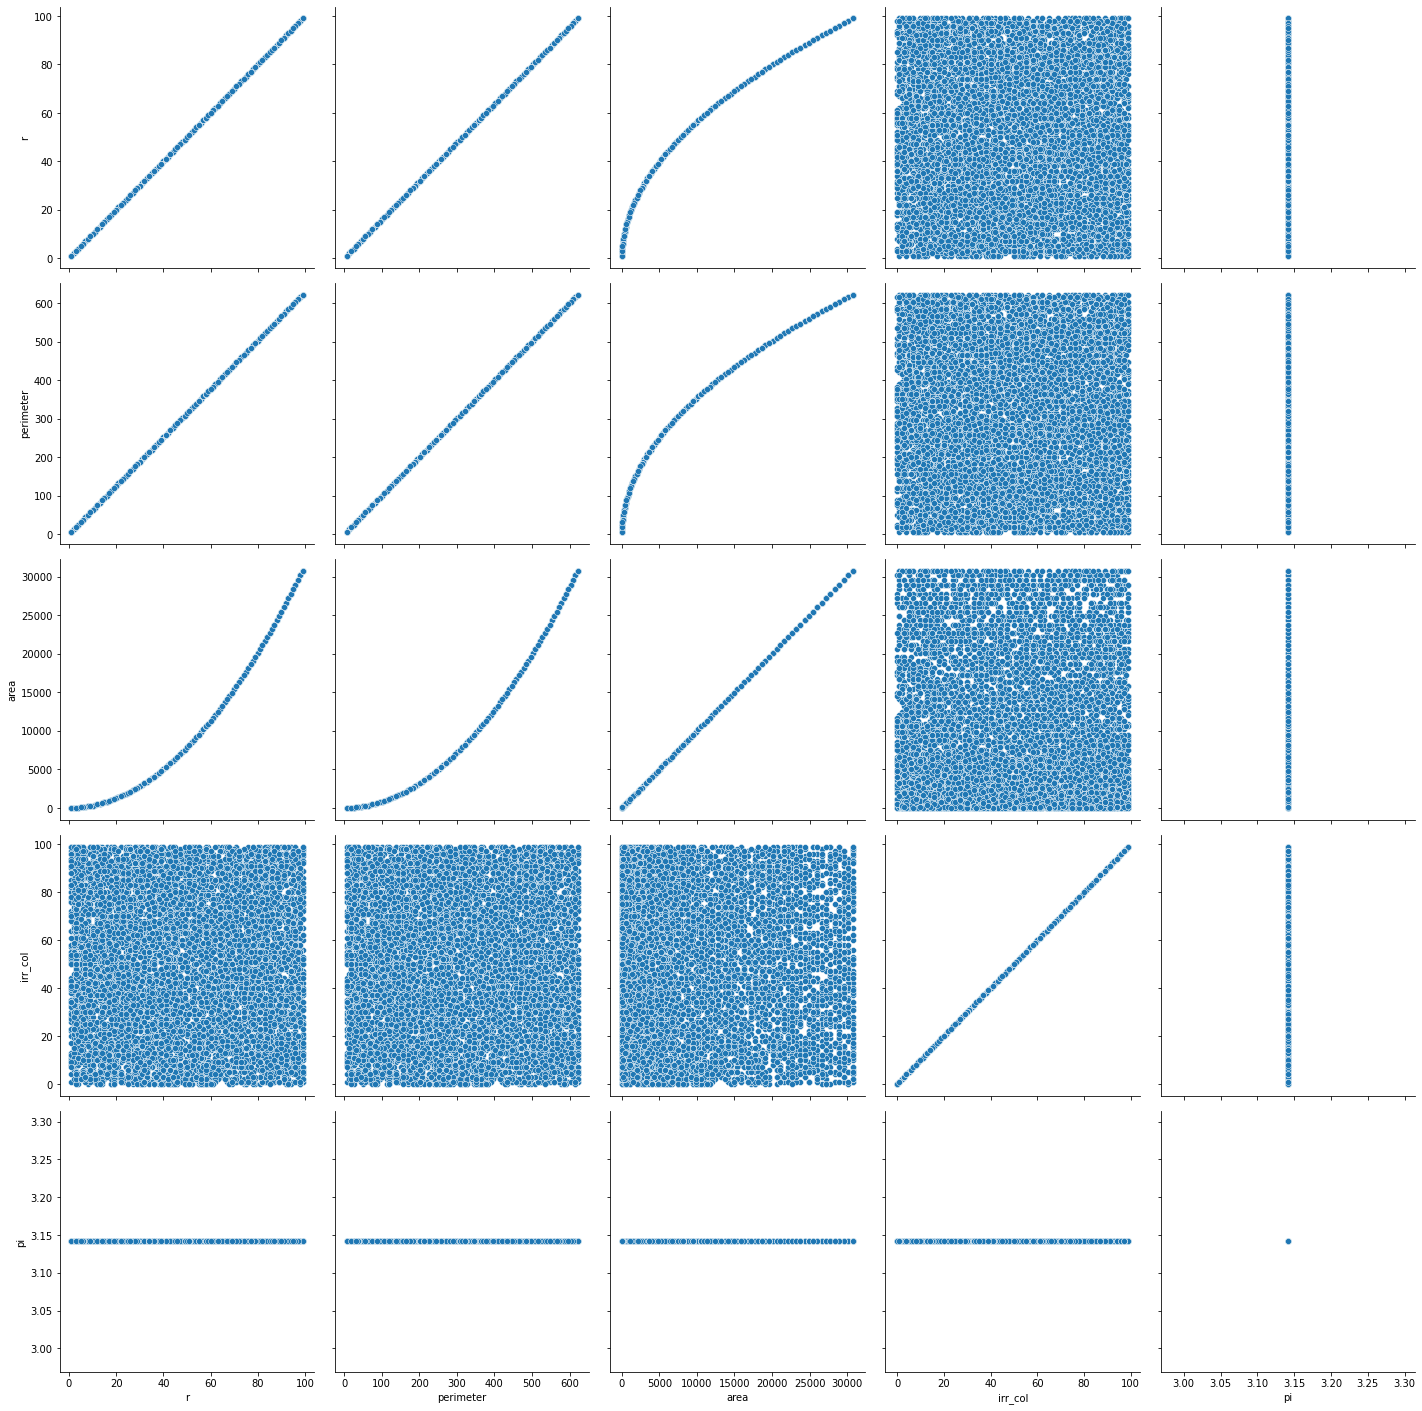

In [4]:
g = sns.PairGrid(circle_train, height=4)
g.map(sns.scatterplot)

---

## Modeling

In [5]:
results = pd.DataFrame({'Test Type': pd.Series([], dtype='str'), 
                        'Features': pd.Series([], dtype='object'), 
                        'RMSE': pd.Series([], dtype='float')})

In [6]:
from sklearn.metrics import mean_squared_error

def test_model(model, cols, test_type):
    # Fit the model
    model.fit(X_train[cols], y_train)

    # Prediction
    pred = model.predict(X_test[cols])

    # Calculate RMSE
    rmse = mt.sqrt(mean_squared_error(y_test, pred))
            
    results.loc[len(results), :] = np.array([test_type, cols, rmse], dtype=object)
    print(f'Features: {cols}')
    print(f"RMSE: {rmse}")
    print()

---

### XGBoost - Predict area

In [7]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [8]:
from xgboost import XGBRegressor

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [9]:
# 4 features
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi'], test_type = 'XGBoost')

# 3 features
test_model(model, cols=['r', 'perimeter', 'pi'], test_type = 'XGBoost')
test_model(model, cols=['r', 'perimeter', 'irr_col'], test_type = 'XGBoost')
test_model(model, cols=['r', 'irr_col', 'pi'], test_type = 'XGBoost')

# 2 features
test_model(model, cols=['r', 'perimeter'], test_type = 'XGBoost')
test_model(model, cols=['r', 'irr_col'], test_type = 'XGBoost')
test_model(model, cols=['r', 'pi'], test_type = 'XGBoost')

# 1 feature
test_model(model, cols=['r'], test_type = 'XGBoost')
test_model(model, cols=['perimeter'], test_type = 'XGBoost')

Features: ['r', 'perimeter', 'irr_col', 'pi']
RMSE: 0.9984861190759728

Features: ['r', 'perimeter', 'pi']
RMSE: 0.18662965421505567

Features: ['r', 'perimeter', 'irr_col']
RMSE: 0.4058392426876401

Features: ['r', 'irr_col', 'pi']
RMSE: 2.6609839673951035

Features: ['r', 'perimeter']
RMSE: 0.042235383325839815

Features: ['r', 'irr_col']
RMSE: 0.9648756340014458

Features: ['r', 'pi']
RMSE: 0.48181033322206646

Features: ['r']
RMSE: 0.042235383325839815

Features: ['perimeter']
RMSE: 0.042235383325839815



In [10]:
# All features / r
0.9984861190759728 / 0.042235383325839815

23.640986311709266

---

## PCA

In [11]:
from sklearn.decomposition import PCA

def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings

In [12]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [13]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [14]:
%%time

# Review the MI score from the raw numerical data
num_mi_scores = pd.DataFrame(make_mi_scores(X_train, y_train))

num_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

CPU times: user 652 ms, sys: 39.1 ms, total: 691 ms
Wall time: 331 ms


,MI Scores
perimeter,4.597979
r,4.594437
pi,0.002688
irr_col,0.000000


In [15]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [16]:
pca, X_pca, loadings = apply_pca(X_train)
loadings

,PC1,PC2,PC3,PC4
r,7.070085e-01,1.178914e-02,-7.004391e-01,-9.687645e-02
perimeter,7.070085e-01,1.178914e-02,7.004391e-01,9.687645e-02
irr_col,-1.667237e-02,9.998610e-01,-5.204170e-18,-4.336809e-19
pi,2.358557e-33,-9.591427e-32,1.370040e-01,-9.905705e-01


In [17]:
pca_mi_scores = pd.DataFrame(make_mi_scores(X_pca, y_train))

pca_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,MI Scores
PC1,4.384154
PC3,3.072715
PC4,3.071960
PC2,0.164496


---

### Use PCA as new features

In [18]:
X_train = circle_train.copy()
X_train = X_train.join(X_pca)
y_train = X_train.pop('area')

_pca, X_pca_test, _loadings = apply_pca(X_test)

X_test = circle_test.copy()
X_test = X_test.join(X_pca_test)
y_test = X_test.pop('area')

In [19]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [20]:
# 5 features
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')

# 4 features
test_model(model, cols=['r', 'perimeter', 'pi', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['r', 'perimeter', 'irr_col', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['r', 'irr_col', 'pi', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')

# 3 features
test_model(model, cols=['r', 'perimeter', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['r', 'irr_col', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['r', 'pi', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')

# 2 features
test_model(model, cols=['r', 'PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['r', 'perimeter', 'PC1'], test_type = 'add pca')
test_model(model, cols=['r', 'perimeter'], test_type = 'add pca')
test_model(model, cols=['r', 'PC1'], test_type = 'add pca')

# 1 feature
test_model(model, cols=['r'], test_type = 'add pca')
test_model(model, cols=['perimeter'], test_type = 'add pca')
test_model(model, cols=['PC1', 'PC2', 'PC3', 'PC4'], test_type = 'add pca')
test_model(model, cols=['PC1'], test_type = 'add pca')

Features: ['r', 'perimeter', 'irr_col', 'pi', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 8019.926656495792

Features: ['r', 'perimeter', 'pi', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 6076.970159228766

Features: ['r', 'perimeter', 'irr_col', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 6512.205579836106

Features: ['r', 'irr_col', 'pi', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 8056.9057558333

Features: ['r', 'perimeter', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 7554.3603367383985

Features: ['r', 'irr_col', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 10149.316422026053

Features: ['r', 'pi', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 10162.4533213844

Features: ['r', 'PC1', 'PC2', 'PC3', 'PC4']
RMSE: 9030.92008643984

Features: ['r', 'perimeter', 'PC1']
RMSE: 6110.292741816724

Features: ['r', 'perimeter']
RMSE: 0.042235383325839815

Features: ['r', 'PC1']
RMSE: 8983.780492814645

Features: ['r']
RMSE: 0.042235383325839815

Features: ['perimeter']
RMSE: 0.042235383325839815

Features: ['PC1', 'PC2', 'PC3', 'PC4']
RMSE: 17672.84258053053

Feat

In [21]:
# All features / r
8019.926656495792 / 0.042235383325839815

189886.44176905483

---

### Use PCA to create a new feature

In [22]:
loadings

,PC1,PC2,PC3,PC4
r,7.070085e-01,1.178914e-02,-7.004391e-01,-9.687645e-02
perimeter,7.070085e-01,1.178914e-02,7.004391e-01,9.687645e-02
irr_col,-1.667237e-02,9.998610e-01,-5.204170e-18,-4.336809e-19
pi,2.358557e-33,-9.591427e-32,1.370040e-01,-9.905705e-01


In [23]:
pca_mi_scores.style.bar(align='mid', color=['#d65f5f', '#5fba7d'])

,MI Scores
PC1,4.384154
PC3,3.072715
PC4,3.071960
PC2,0.164496


In [24]:
X_train = circle_train.copy()
y_train = X_train.pop('area')
X_train['pca'] = X_train['r'] * X_train['pi']

X_test = circle_test.copy()
y_test = X_test.pop('area')
X_test['pca'] = X_test['r'] * X_test['pi']

In [25]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [26]:
# 5 features
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi', 'pca'], test_type = 'create feature')

# 4 features
test_model(model, cols=['r', 'perimeter', 'pi', 'pca'], test_type = 'create feature')
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pca'], test_type = 'create feature')
test_model(model, cols=['r', 'irr_col', 'pi', 'pca'], test_type = 'create feature')

# 3 features
test_model(model, cols=['r', 'perimeter', 'pca'], test_type = 'create feature')
test_model(model, cols=['r', 'irr_col', 'pca'], test_type = 'create feature')
test_model(model, cols=['r', 'pi', 'pca'], test_type = 'create feature')

# 2 features
test_model(model, cols=['r', 'pca'], test_type = 'create feature')
test_model(model, cols=['r', 'perimeter'], test_type = 'create feature')

# 1 feature
test_model(model, cols=['r'], test_type = 'create feature')
test_model(model, cols=['perimeter'], test_type = 'create feature')
test_model(model, cols=['pca'], test_type = 'create feature')

Features: ['r', 'perimeter', 'irr_col', 'pi', 'pca']
RMSE: 0.80061632912128

Features: ['r', 'perimeter', 'pi', 'pca']
RMSE: 0.07827639408244323

Features: ['r', 'perimeter', 'irr_col', 'pca']
RMSE: 0.23894499020175122

Features: ['r', 'irr_col', 'pi', 'pca']
RMSE: 0.9067773827764786

Features: ['r', 'perimeter', 'pca']
RMSE: 0.042235383325839815

Features: ['r', 'irr_col', 'pca']
RMSE: 0.42859536057934267

Features: ['r', 'pi', 'pca']
RMSE: 0.2127647766198848

Features: ['r', 'pca']
RMSE: 0.042235383325839815

Features: ['r', 'perimeter']
RMSE: 0.042235383325839815

Features: ['r']
RMSE: 0.042235383325839815

Features: ['perimeter']
RMSE: 0.042235383325839815

Features: ['pca']
RMSE: 0.042235383325839815



In [27]:
# All features / r
0.80061632912128 / 0.042235383325839815

18.95605689060857

---

## Outliers

### Outliers that not yiled the model

In [28]:
X_train = circle_train.copy()
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [29]:
# Add 1% random data from 500 to 1000 to circle_train
n = int(len(circle_train) * 0.01)

outliers = pd.DataFrame(columns=circle_train.columns)
outliers['r'] = rng.integers(low=500, high=1000, size=n)
outliers['perimeter'] = rng.integers(low=500, high=1000, size=n)
outliers['area'] = rng.integers(low=500, high=1000, size=n)
outliers['irr_col'] = rng.integers(low=500, high=1000, size=n)
outliers['pi'] = [mt.pi] * n

X_train = pd.concat([X_train, outliers], axis=0)
y_train = X_train.pop('area')

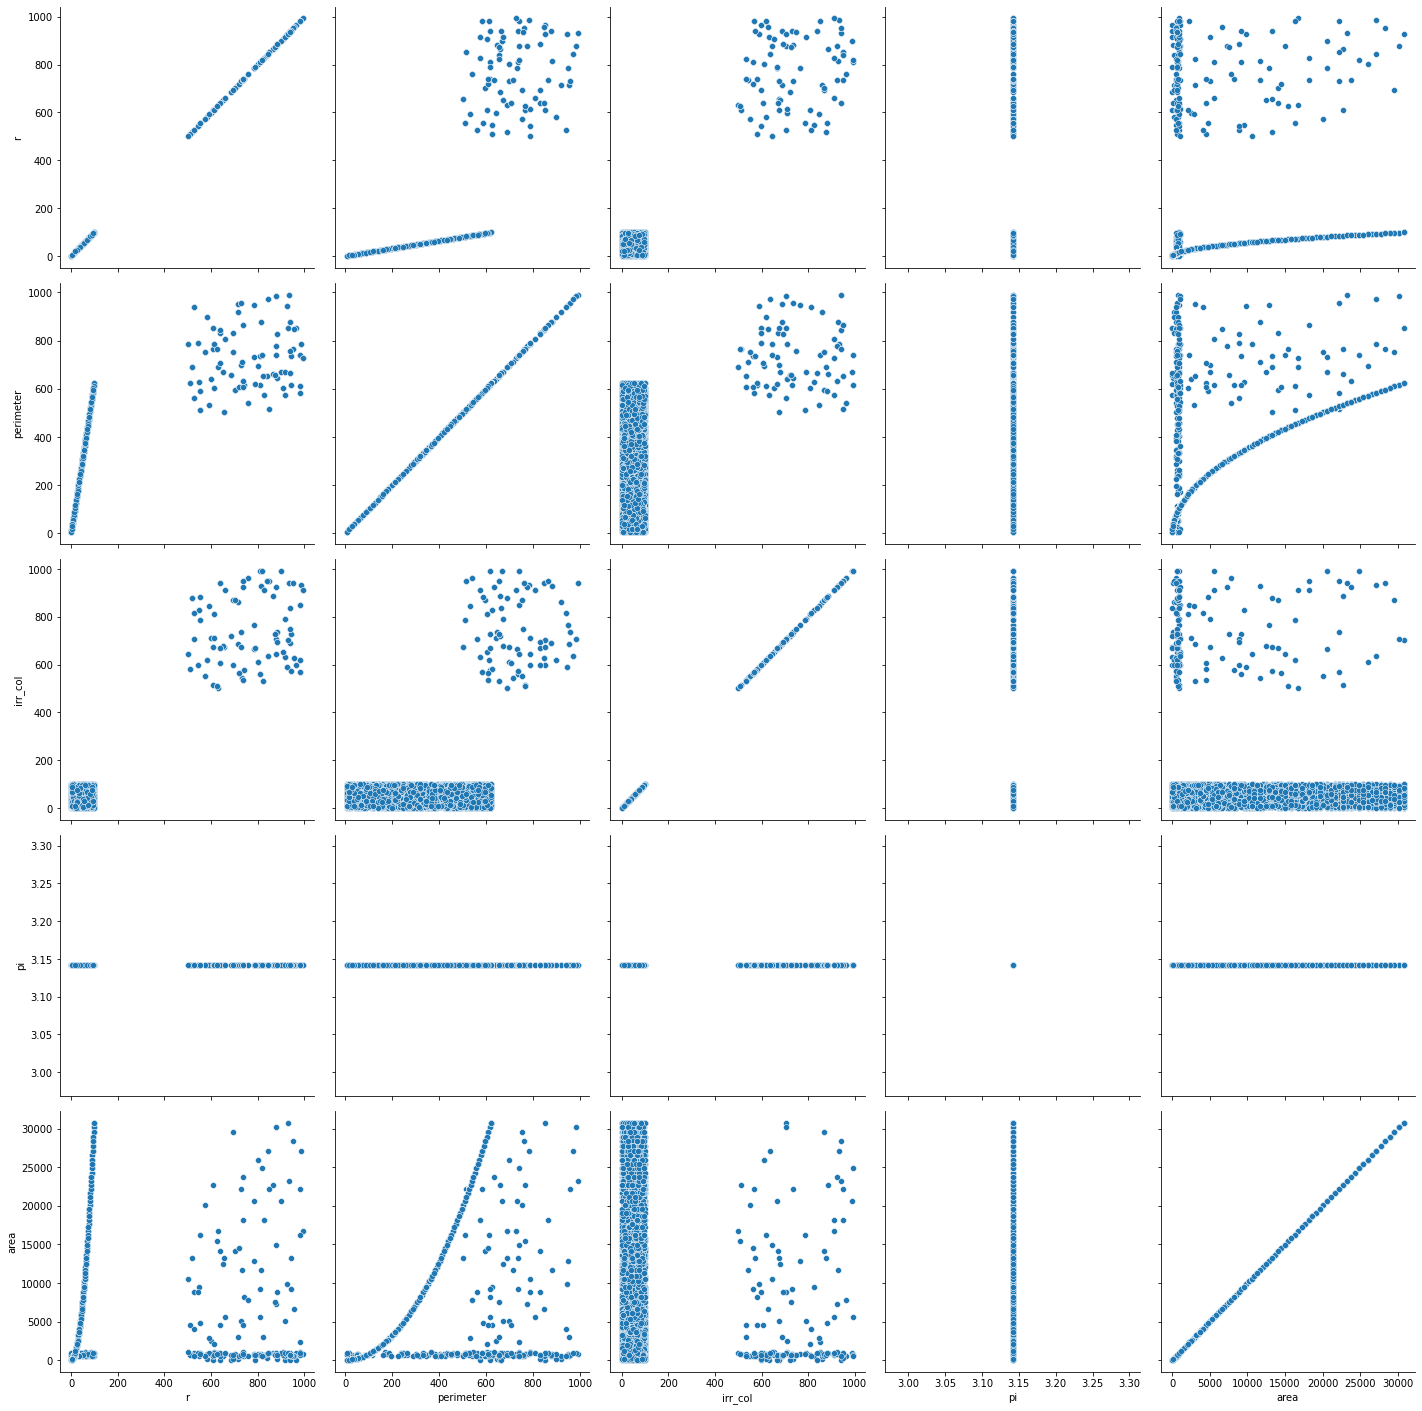

In [30]:
g = sns.PairGrid(X_train.join(y_train), height=4)
g.map(sns.scatterplot)

In [31]:
from xgboost import XGBRegressor

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [32]:
# 4 features
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi'], test_type = 'random outliers')

# 3 features
test_model(model, cols=['r', 'perimeter', 'pi'], test_type = 'random outliers')
test_model(model, cols=['r', 'perimeter', 'irr_col'], test_type = 'random outliers')
test_model(model, cols=['r', 'irr_col', 'pi'], test_type = 'random outliers')

# 2 features
test_model(model, cols=['r', 'perimeter'], test_type = 'random outliers')
test_model(model, cols=['r', 'irr_col'], test_type = 'random outliers')
test_model(model, cols=['r', 'pi'], test_type = 'random outliers')

# 1 feature
test_model(model, cols=['r'], test_type = 'random outliers')
test_model(model, cols=['perimeter'], test_type = 'random outliers')

Features: ['r', 'perimeter', 'irr_col', 'pi']
RMSE: 7.168778934795315

Features: ['r', 'perimeter', 'pi']
RMSE: 8.605018444997054

Features: ['r', 'perimeter', 'irr_col']
RMSE: 6.229556438052758

Features: ['r', 'irr_col', 'pi']
RMSE: 5.417918766278255

Features: ['r', 'perimeter']
RMSE: 5.33547277590768

Features: ['r', 'irr_col']
RMSE: 2.3916015957630945

Features: ['r', 'pi']
RMSE: 3.5614053551390232

Features: ['r']
RMSE: 0.8580909183115653

Features: ['perimeter']
RMSE: 3.017250869935615



In [33]:
# All features / r
7.168778934795315 / 0.8580909183115653

8.35433493329712

---

### Outliers that yields the model

In [34]:
X_train = circle_train.copy()
X_test = circle_test.copy()
y_test = X_test.pop('area')

In [35]:
# Add 1% random data from 500 to 1000 to circle_train
n = int(len(circle_train) * 0.01)

outliers = pd.DataFrame(columns=circle_train.columns)
outliers['r'] = rng.integers(low=500, high=1000, size=n)
outliers['perimeter'] = 2 * mt.pi * outliers['r']
outliers['area'] = mt.pi * outliers['r']**2
outliers['irr_col'] = rng.integers(low=500, high=1000, size=n)
outliers['pi'] = [mt.pi] * n

X_train = pd.concat([X_train, outliers], axis=0)
y_train = X_train.pop('area')

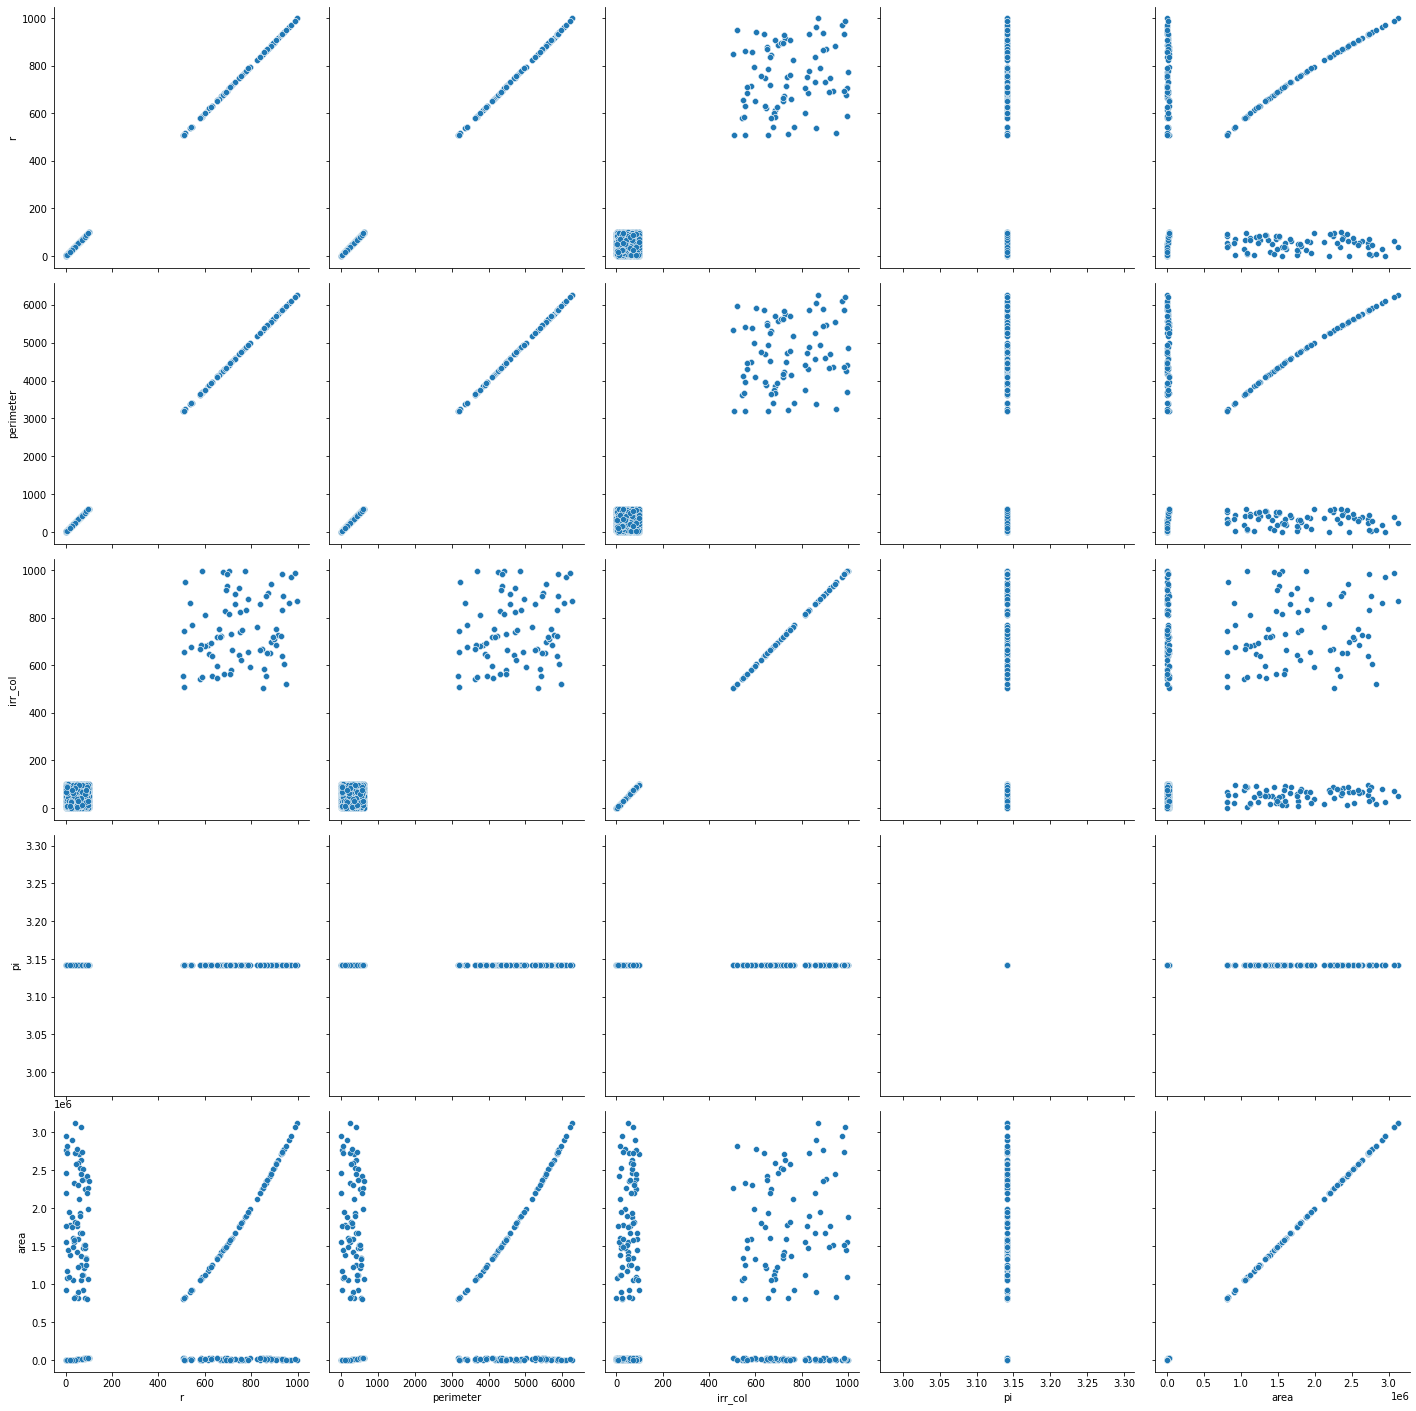

In [36]:
g = sns.PairGrid(X_train.join(y_train), height=4)
g.map(sns.scatterplot)

In [37]:
from xgboost import XGBRegressor

# Model hyperparameters
xgb_params = {'n_estimators': 1000,
              'learning_rate': 0.1,
              #'subsample': 0.8,
              'colsample_bytree': 0.3,
              'max_depth': 3,
              'booster': 'gbtree', 
              #'reg_lambda': 45.1,
              #'reg_alpha': 34.9,
              'random_state': 0,
              'n_jobs': 8}

model = XGBRegressor(**xgb_params)

In [38]:
# 4 features
test_model(model, cols=['r', 'perimeter', 'irr_col', 'pi'], test_type = 'special outliers')

# 3 features
test_model(model, cols=['r', 'perimeter', 'pi'], test_type = 'special outliers')
test_model(model, cols=['r', 'perimeter', 'irr_col'], test_type = 'special outliers')
test_model(model, cols=['r', 'irr_col', 'pi'], test_type = 'special outliers')

# 2 features
test_model(model, cols=['r', 'perimeter'], test_type = 'special outliers')
test_model(model, cols=['r', 'irr_col'], test_type = 'special outliers')
test_model(model, cols=['r', 'pi'], test_type = 'special outliers')

# 1 feature
test_model(model, cols=['r'], test_type = 'special outliers')
test_model(model, cols=['perimeter'], test_type = 'special outliers')

Features: ['r', 'perimeter', 'irr_col', 'pi']
RMSE: 77.45243107819543

Features: ['r', 'perimeter', 'pi']
RMSE: 46.06521161580143

Features: ['r', 'perimeter', 'irr_col']
RMSE: 46.9725723466845

Features: ['r', 'irr_col', 'pi']
RMSE: 156.98773148463448

Features: ['r', 'perimeter']
RMSE: 16.290058718036455

Features: ['r', 'irr_col']
RMSE: 71.10096470283172

Features: ['r', 'pi']
RMSE: 76.59983380601318

Features: ['r']
RMSE: 16.290058718036455

Features: ['perimeter']
RMSE: 16.290058718036455



In [39]:
# All features / r
77.45243107819543 / 16.290058718036455

4.754582682531378

---

## Conclusion

In [40]:
results

,Test Type,Features,RMSE
0,XGBoost,"[r, perimeter, irr_col, pi]",0.998486
1,XGBoost,"[r, perimeter, pi]",0.186630
2,XGBoost,"[r, perimeter, irr_col]",0.405839
3,XGBoost,"[r, irr_col, pi]",2.660984
4,XGBoost,"[r, perimeter]",0.042235
5,XGBoost,"[r, irr_col]",0.964876
6,XGBoost,"[r, pi]",0.481810
7,XGBoost,[r],0.042235
8,XGBoost,[perimeter],0.042235
9,add pca,"[r, perimeter, irr_col, pi, PC1, PC2, PC3, PC4]",8019.926656


As we can see, wrong pca features destroy the model.<br>
Except wrong pcas, outliers hurt the performance much better than others.<br>
Another way to improve the performance is to elimate the irrevelant features, such as constant varaible, noises. 

In [41]:
# Add pca reducing too much performance, so drop 'Test Type' == 'add pca'
results[results['Test Type'] != 'add pca'].sort_values(by='RMSE', ascending=False).style.bar(align='mid', color=['#d65f5f'])

,Test Type,Features,RMSE
48,special outliers,"['r', 'irr_col', 'pi']",156.987731
45,special outliers,"['r', 'perimeter', 'irr_col', 'pi']",77.452431
51,special outliers,"['r', 'pi']",76.599834
50,special outliers,"['r', 'irr_col']",71.100965
47,special outliers,"['r', 'perimeter', 'irr_col']",46.972572
46,special outliers,"['r', 'perimeter', 'pi']",46.065212
53,special outliers,['perimeter'],16.290059
49,special outliers,"['r', 'perimeter']",16.290059
52,special outliers,['r'],16.290059
37,random outliers,"['r', 'perimeter', 'pi']",8.605018
